In [2]:
from math import sqrt

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


from scipy import ndimage as ndi

import os

# Import an image, convert to grayscale and display

Source: http://www.scipy-lectures.org/advanced/image_processing/

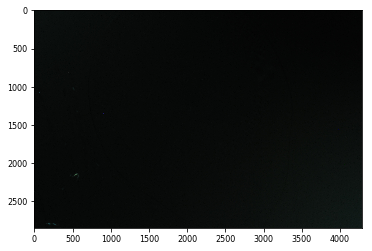

In [32]:
f = io.imread('DSC_5480.JPG')
plt.figure(0)
plt.imshow(f)

(2848, 4288)

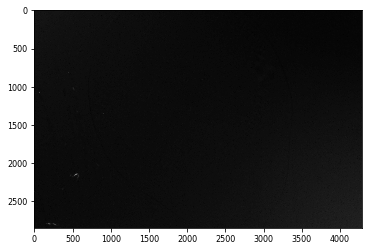

In [33]:
f_grey = rgb2gray(f)
plt.figure(1)
plt.imshow(f_grey, cmap=plt.cm.gray)
f_grey.shape

Crop an image by selecting part of the numpy array

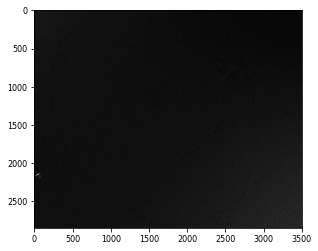

In [34]:
f_cropped = f_grey[0:2848,500:4000]
plt.figure(2)
plt.imshow(f_cropped, cmap=plt.cm.gray)

/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


9.898459169341894

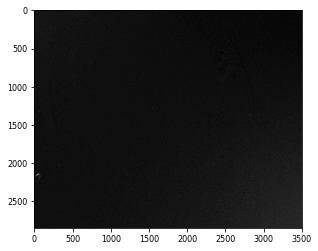

In [35]:
f_uint = img_as_ubyte(f_cropped)
plt.figure(3)
plt.imshow(f_uint, cmap=plt.cm.gray)
f_uint.mean()

# Histogram Equalization techniques

Source: https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py

In [36]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [37]:
img = f_uint
matplotlib.rcParams['font.size'] = 8

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

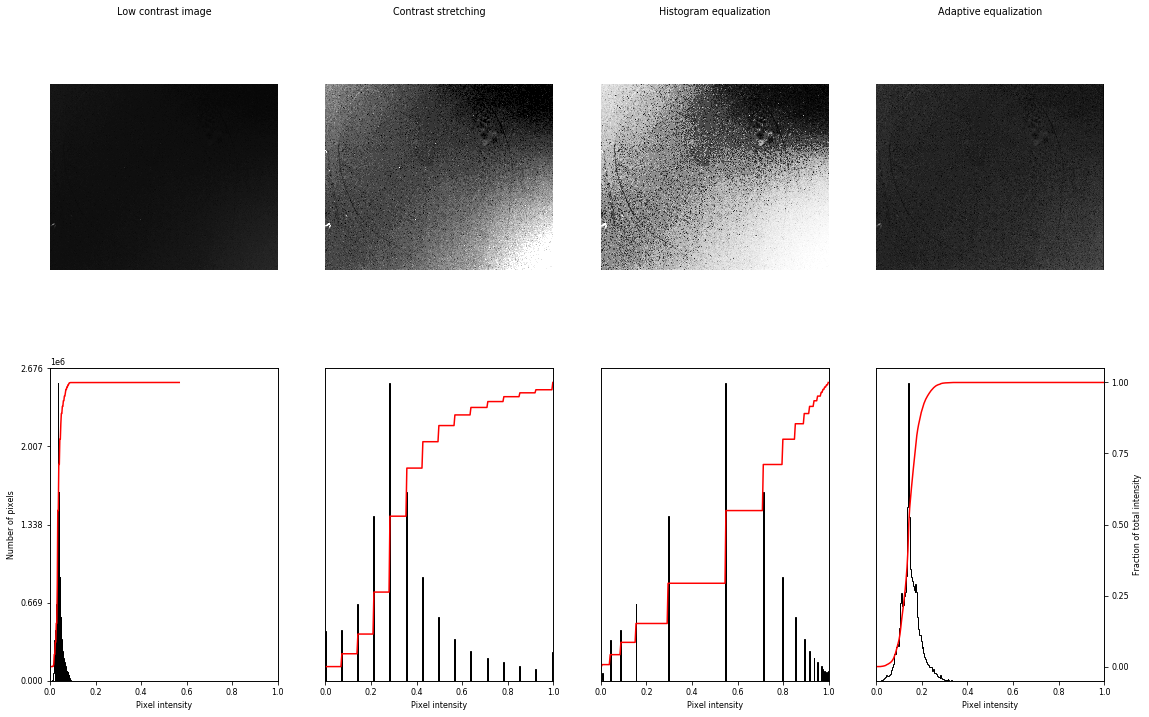

In [38]:
# Display results
fig = plt.figure(figsize=(16, 10))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

Text(0.5,1,'Contrast Stretching')

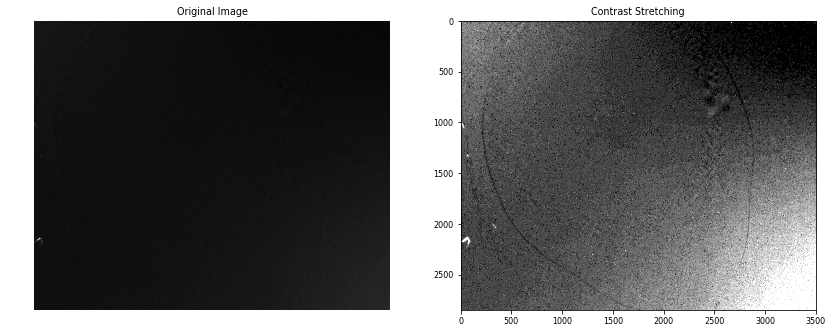

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
axes[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(img_rescale, cmap=plt.cm.gray, interpolation='nearest')
axes[1].set_title('Contrast Stretching')

# Image Segmentation

Source: https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html

Plot a histogram of the pixel intensity values to determine possible thresholding values

Text(0.5,1,'histogram of gray values')

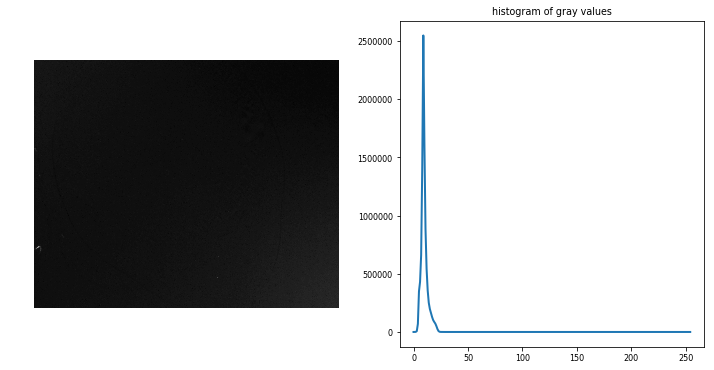

In [40]:
hist = np.histogram(img, bins=np.arange(0, 256))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist[1][:-1], hist[0], lw=2)
axes[1].set_title('histogram of gray values')


## Thresholding

### Simple thresholding 
Works but is very sensitive to background uniformity

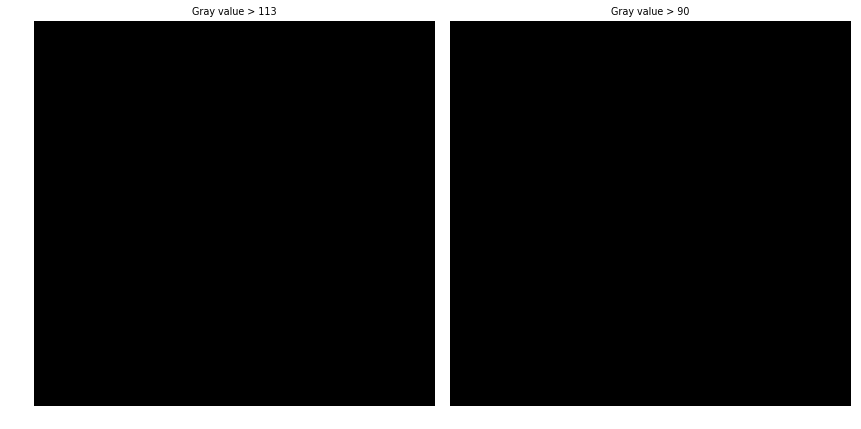

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].imshow(img > 113, cmap=plt.cm.gray, interpolation='nearest')
axes[0].set_title('Gray value > 113')

axes[1].imshow(img > 90, cmap=plt.cm.gray, interpolation='nearest')
axes[1].set_title('Gray value > 90')

for a in axes:
    a.axis('off')

plt.tight_layout()

### Hysteresis thresholding

Source: https://scikit-image.org/docs/dev/auto_examples/filters/plot_hysteresis.html#sphx-glr-auto-examples-filters-plot-hysteresis-py

In [42]:
# Perform edge detection with Sobel gradient
edges = filters.sobel(img)

# Define the low and high thresholds
low = 0.05
high = 0.15

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)

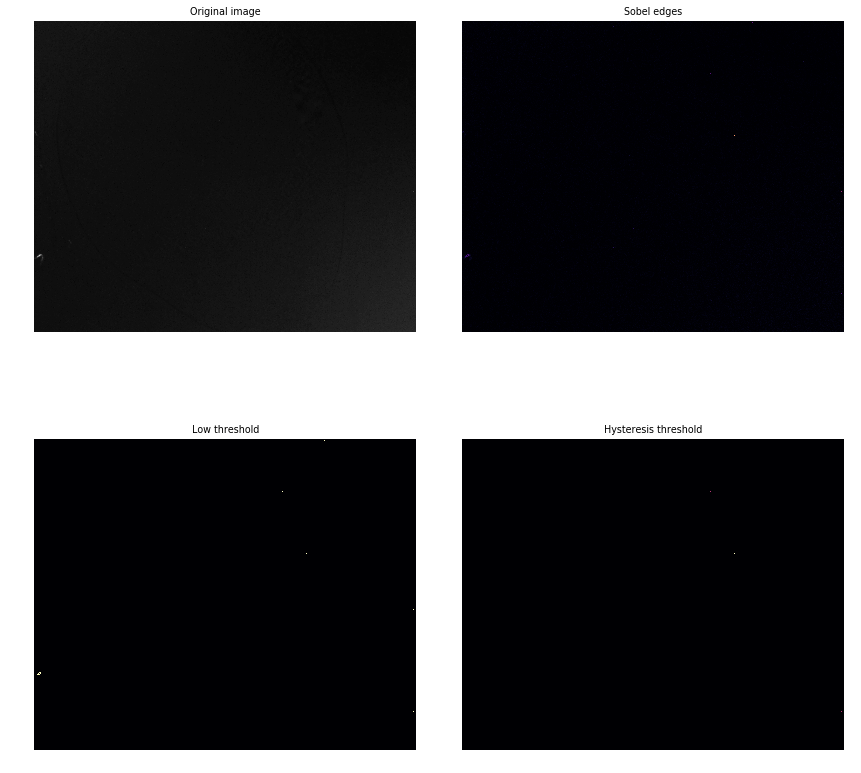

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight + hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()

### Otsu's thresholding

Source: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html#sphx-glr-auto-examples-segmentation-plot-thresholding-py

Uses Otsu's method to determine the 'optimal' threshold by maximizing the variance between two classes of pixels, which are separated by the threshold. Equivalently, this threshold minimizes the intra-class variance.

11


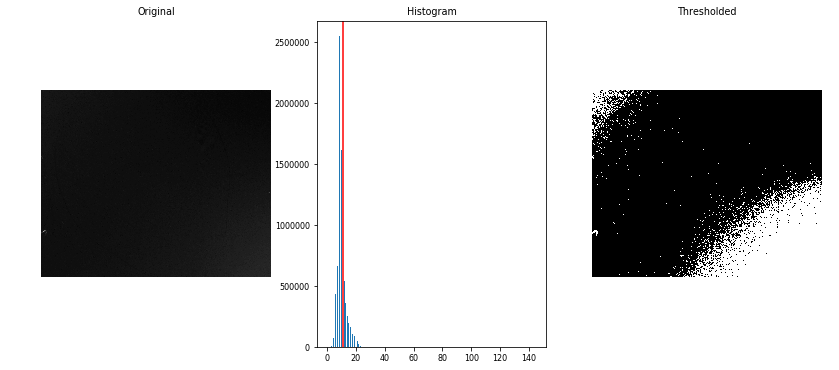

In [44]:
image = img

thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(14, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print(thresh)
plt.show()

### Adaptive Thresholding

Source: http://scikit-image.org/docs/0.12.x/auto_examples/segmentation/plot_threshold_adaptive.html

Uses a local threshold determined in regions of size block_size around each pixel.

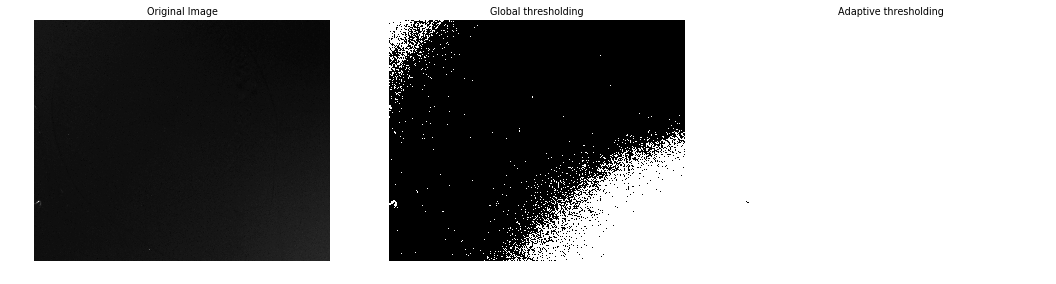

In [45]:
image = img

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 35 # Must be odd!
adaptive_thresh = threshold_local(image, block_size, offset=10)
binary_adaptive = image > adaptive_thresh

fig, axes = plt.subplots(ncols=3, figsize=(18, 12))
ax0, ax1, ax2 = axes
plt.gray()

ax0.imshow(image)
ax0.set_title('Original Image')

ax1.imshow(binary_global)
ax1.set_title('Global thresholding')

ax2.imshow(binary_adaptive)
ax2.set_title('Adaptive thresholding')

for ax in axes:
    ax.axis('off')

plt.show()

### Try all thresholding

Source: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html#sphx-glr-auto-examples-segmentation-plot-thresholding-py

Function from Scikit-image to evaluate the different threshold determination functions provided in the filters module.

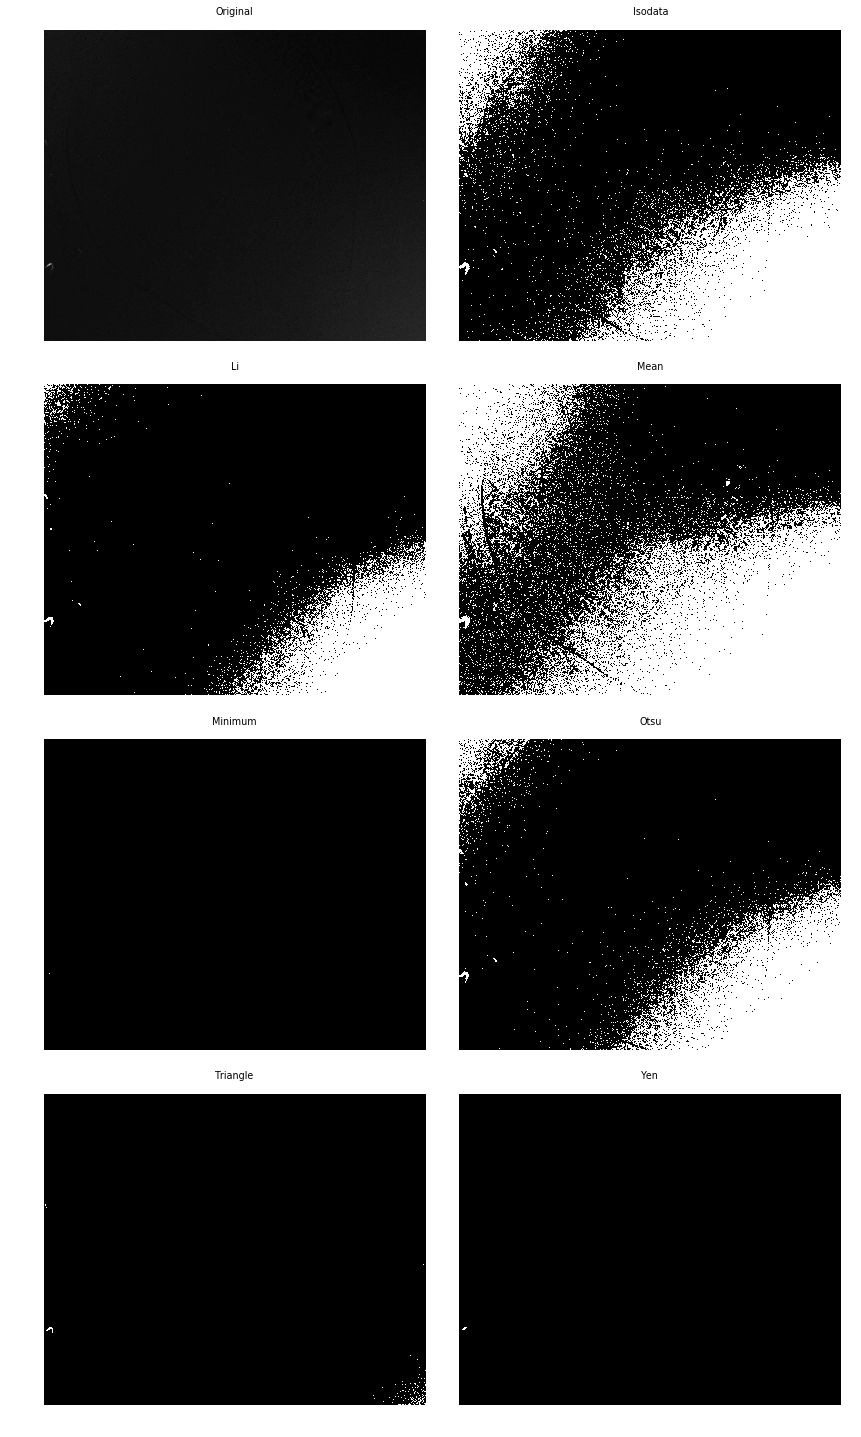

In [46]:
fig, ax = try_all_threshold(img, figsize=(12, 20), verbose=False)
plt.show()

### Minimum Threshold method

Text(0.5,1,'Minimum Threshold')

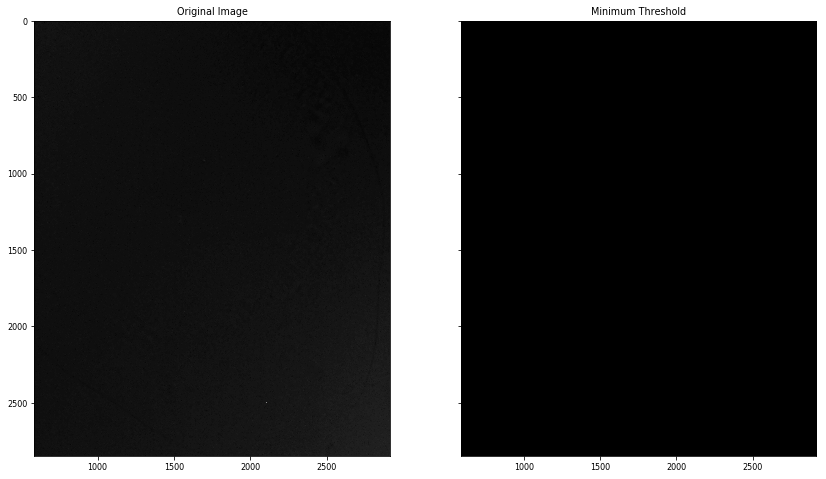

In [47]:
img_min_thresh = img > threshold_minimum(img)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

axes[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
axes[0].set_title('Original Image')

axes[1].imshow(img_min_thresh, cmap=plt.cm.gray, interpolation='nearest')
axes[1].set_title('Minimum Threshold')

## Edge based segmentation

(-0.5, 3499.5, 2847.5, -0.5)

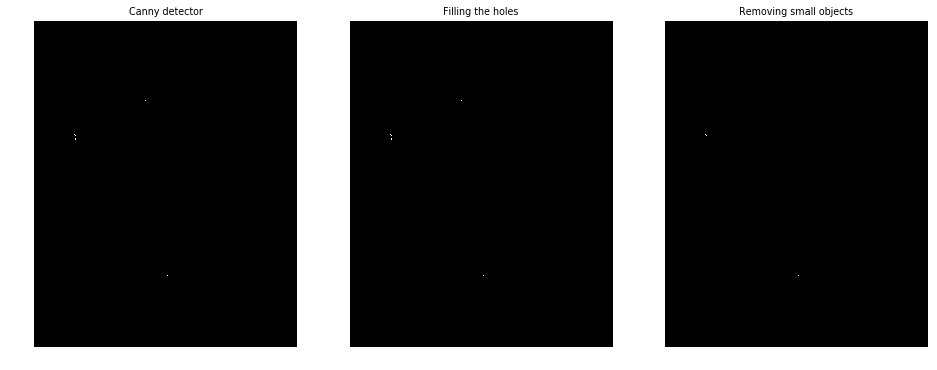

In [23]:
#Detect the edges using a canny detector
edges = canny(img, sigma = 2)

#Fill the contours using mathematical morphology
filled = ndi.binary_fill_holes(edges)

#Remove small objects using a minimum size
cleaned = morphology.remove_small_objects(filled, 21)


fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

axes[0].imshow(edges, cmap=plt.cm.gray, interpolation='nearest')
axes[0].set_title('Canny detector')
axes[0].axis('off')

axes[1].imshow(filled, cmap=plt.cm.gray, interpolation='nearest')
axes[1].set_title('Filling the holes')
axes[1].axis('off')

axes[2].imshow(cleaned, cmap=plt.cm.gray, interpolation='nearest')
axes[2].set_title('Removing small objects')
axes[2].axis('off')

Results are pretty good:
- Shapes are mostly closed
- Detection efficiency is pretty good

But
- Contours are that are not perfectly closed are not filled correctly
- Large variability introduced by filling the holes

## Region-based segmentation

Region-based method is based on the watershed transform.
First, an elevation map is created using the Sobel gradient of the image.

(-0.5, 3499.5, 2847.5, -0.5)

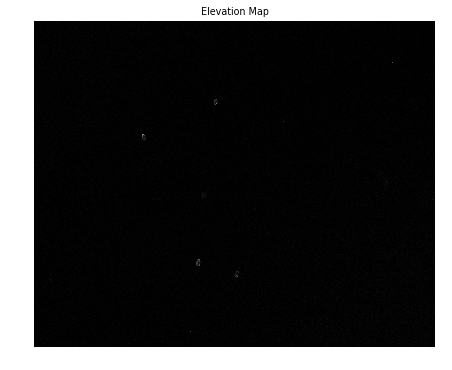

In [24]:
elevation_map = sobel(img)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Elevation Map')
ax.axis('off')

Next, we identify regions solidly in the background or part of the crystal from the histogram of the greyscale values

(-0.5, 3499.5, 2847.5, -0.5)

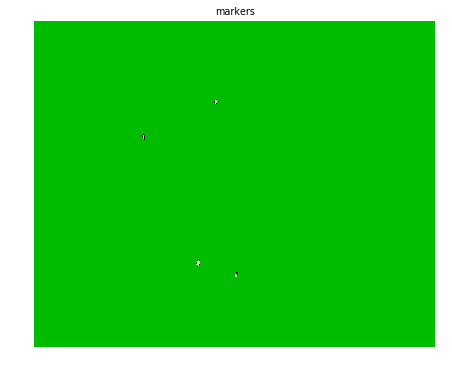

In [29]:
markers = np.zeros_like(img)
markers[img < 60] = 1
markers[img > 100] = 2

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax.set_title('markers')
ax.axis('off')

Finally, we use the watershed transform to fill regions of the elevation map starting from the markers determined above

(-0.5, 3499.5, 2847.5, -0.5)

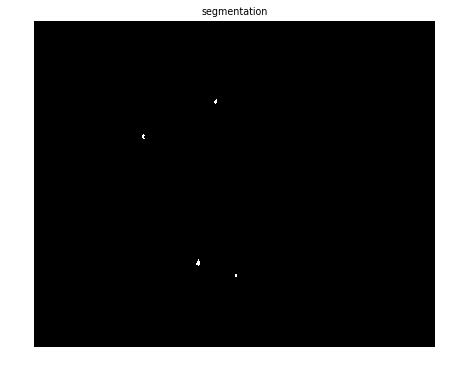

In [30]:
segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmentation')
ax.axis('off')

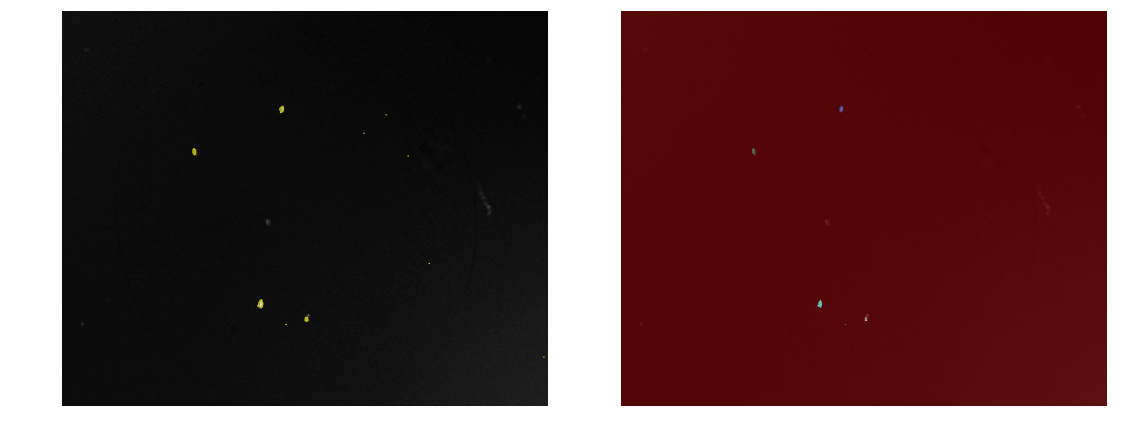

In [31]:
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=img)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
axes[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

## Blob detection

Source: https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html#sphx-glr-auto-examples-features-detection-plot-blob-py

Blobs are bright on dark or dark on bright regions in an image.

There are 3 main algorithms for blob detection:
- Laplacian of Gaussian (LoG): most accurate but slowest. Only bright on dark blobs are detected.
- Difference of Gaussian (DoG): faster. Only bright on dark blobs are detected.
- Determinant of Hessian (DoH): fastest, speed depends on size of blobs. Small blobs (<3px) not detected accurately

In [25]:
# Maker sure the blobs are bright on dark for the blolb detection
#image = util.invert(img)
image = img

#Compute the LoG blobs
blobs_log = blob_log(image, max_sigma=30, num_sigma=10, threshold=.1)

#Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

#Compute the DoG blobs
blobs_dog = blob_dog(image, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

#Compute the DoH blobs
blobs_doh = blob_doh(image, max_sigma=30, threshold=.01)

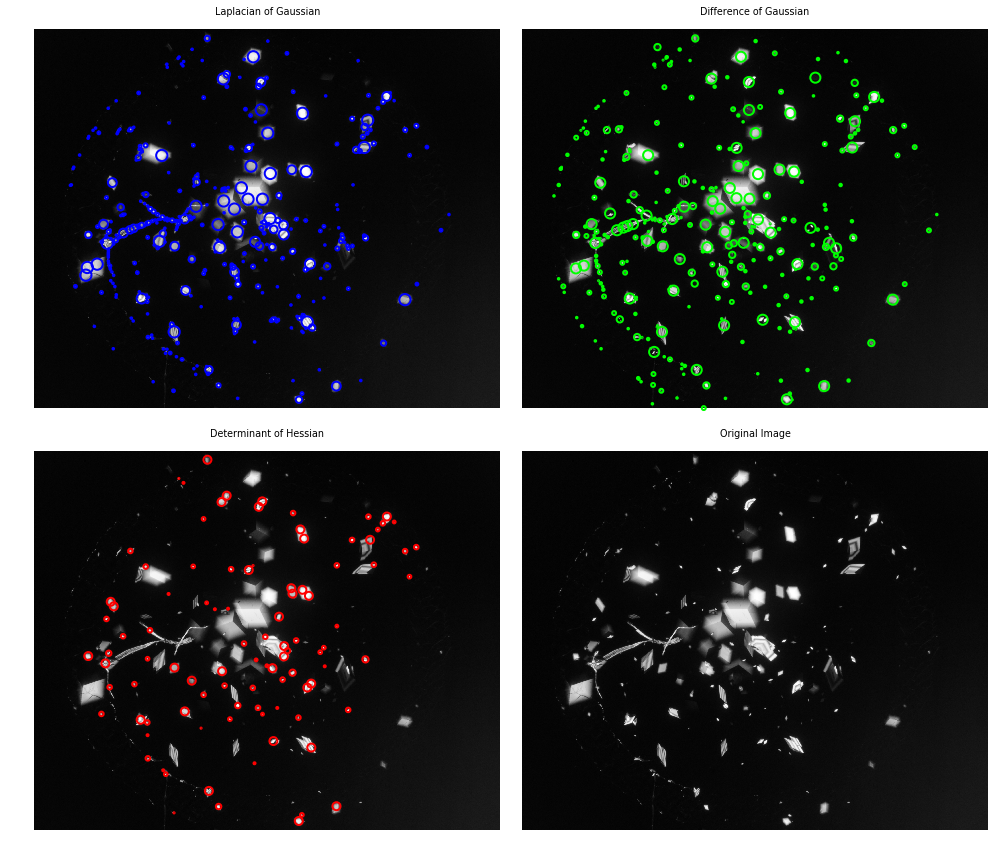

In [26]:
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['blue', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

ax[3].set_title('Original Image')
ax[3].imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax[3].set_axis_off()
    
plt.tight_layout()
plt.show()

# Touch up

Source: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html#sphx-glr-auto-examples-segmentation-plot-label-py

1. Close small holes with binary closing
2. Remove artifacts touching the image border
3. Measure image regions to filter small objects
4. Color label and identify detected regions

Example is provided using Otsu thresholding for instance but can be applied with any segmenting technique

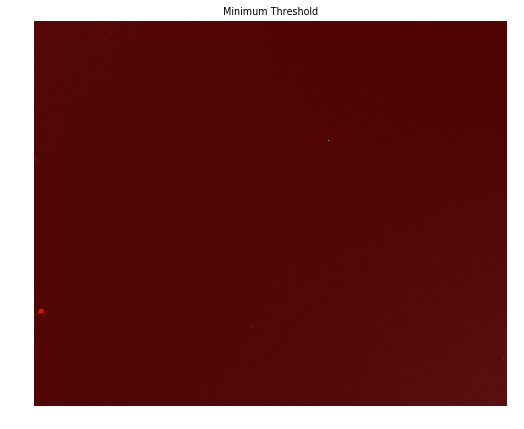

In [48]:
image = img

# apply threshold
thresh = threshold_minimum(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 10:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
ax.set_title('Minimum Threshold')
plt.tight_layout()
plt.savefig('MinThresh.jpg')
plt.show()

In [59]:
regionProperties = regionprops(label_image, intensity_image=image)

67


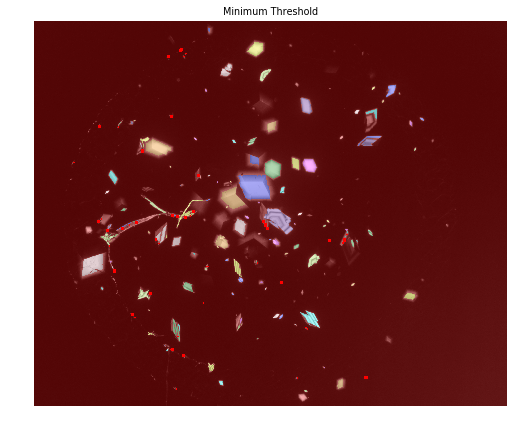

In [60]:
smallCryst = []
for item in regionProperties:
    if item.area < 50:
        smallCryst.append(item)
        
print(len(smallCryst))        

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in smallCryst:
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
ax.set_title('Minimum Threshold')
plt.tight_layout()
plt.savefig('MinThresh.jpg')
plt.show()

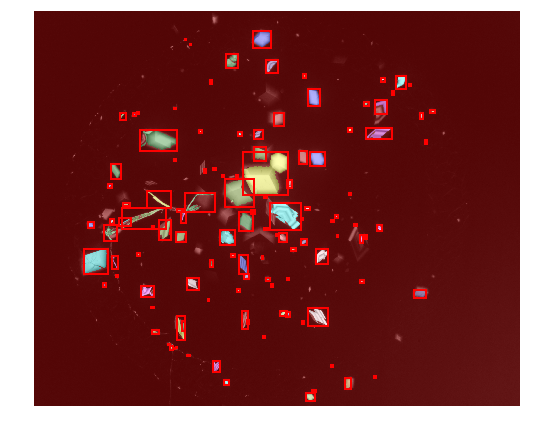

In [61]:
#Close open objects
closed = closing(segmentation)

# remove artifacts connected to image border
cleared = clear_border(closed)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 10:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.savefig('Watershed.jpg')
plt.show()

In [62]:
regionProperties = regionprops(label_image, intensity_image=image)

3


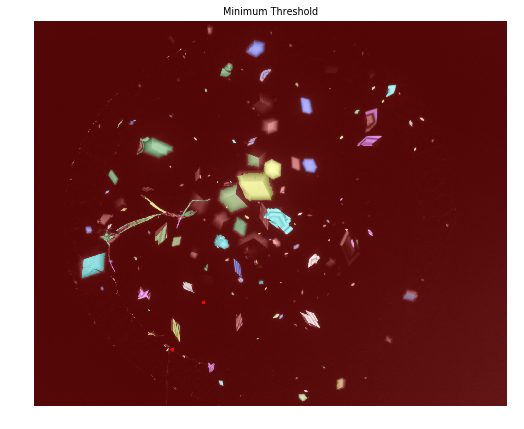

In [63]:
smallCryst = []
for item in regionProperties:
    if item.area < 50:
        smallCryst.append(item)
        
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

print(len(smallCryst))

for region in smallCryst:
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
ax.set_title('Minimum Threshold')
plt.tight_layout()
plt.savefig('MinThresh.jpg')
plt.show()